In [ ]:
!pip install pyspark
!pip install venn -q

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
import venn
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('ds_study').getOrCreate()
spark

# **원본 데이터 읽기**

In [ ]:
members = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/members_v3.csv')
train_v1 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/train.csv')
train_v2 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/train_v2.csv')
transactions_v1 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/transactions.csv')
transactions_v2 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/transactions_v2.csv')
user_logs_v1 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/user_logs.csv')
user_logs_v2 = spark.read.option('inferSchema', 'true').option('header', 'true').csv('./data/user_logs_v2.csv')

# **여러 버전의 데이터 합치기 (Version 1, Version 2)**

* 이탈 여부의 경우, Version 1과 Version 2의 값이 다른 고객이 확인되어 데이터 병합 시 Version 2의 값으로 맞춰주는 작업이 필요함 (예 : Version 1에서는 잔존 유저로 분류되었다가, Version 2에서는 이탈 유저로 분류된 경우 등)
* 서비스 사용 기록이나, 구매 기록의 경우 위와 같은 문제가 없어 단순 병합만 필요함

In [ ]:
# train_v1과 train_v2에 각각 'version'이라는 Column을 만들고 'v1', 'v2'라는 값을 채워넣음
train_v1 = train_v1.withColumn('version', lit('v1'))
train_v2 = train_v2.withColumn('version', lit('v2'))
train_v1.show(2), train_v2.show(2)

+--------------------+--------+-------+
|                msno|is_churn|version|
+--------------------+--------+-------+
|waLDQMmcOu2jLDaV1...|       1|     v1|
|QA7uiXy8vIbUSPOkC...|       1|     v1|
+--------------------+--------+-------+
only showing top 2 rows

+--------------------+--------+-------+
|                msno|is_churn|version|
+--------------------+--------+-------+
|ugx0CjOMzazClkFzU...|       1|     v2|
|f/NmvEzHfhINFEYZT...|       1|     v2|
+--------------------+--------+-------+
only showing top 2 rows



(None, None)

In [ ]:
# train_v1과 train_v2를 Union 연산으로 합친 후 'msno', 'version'의 값에 따라 정렬
# train이라는 변수에 다시 할당하며, 'version'은 내림차순으로 정렬
train = train_v1.union(train_v2).sort(['msno', 'version'], ascending = [1, 0])
train.filter(train.msno.like("++9JUsaZioofS6Fb2%")).show()

+--------------------+--------+-------+
|                msno|is_churn|version|
+--------------------+--------+-------+
|++9JUsaZioofS6Fb2...|       1|     v2|
|++9JUsaZioofS6Fb2...|       0|     v1|
+--------------------+--------+-------+



In [ ]:
# 중복값을 제거하되, 중복 Row 중 첫번째 Row를 남기는 옵션을 선택함
w = Window().partitionBy('msno').orderBy(col('version').desc())
train = train.withColumn('rn', row_number().over(w)).filter(col('rn')==1).drop('rn')
train.filter(train.msno.like("++9JUsaZioofS6Fb2%")).show()

+--------------------+--------+-------+
|                msno|is_churn|version|
+--------------------+--------+-------+
|++9JUsaZioofS6Fb2...|       1|     v2|
+--------------------+--------+-------+



In [ ]:
# version 컬럼 제거
train = train.drop('version')
train.filter(train.msno.like("++9JUsaZioofS6Fb2%")).show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|++9JUsaZioofS6Fb2...|       1|
+--------------------+--------+



In [ ]:
# 서비스 사용 기록과 구매 기록 데이터 합치기
transactions = transactions_v1.union(transactions_v2).sort(['msno', 'transaction_date'])
user_logs = user_logs_v1.union(user_logs_v2).sort(['msno', 'date'])

# **고객 구분 ID를 일련 번호로 대체하기**

* 본 데이터셋에서는 고객을 구분하기 위해 18글자 길이의 해쉬값(예: ++9JUsaZioofS6Fb2%)을 사용하는데, 너무 긴 탓에 한 눈에 고객을 구분하기가 쉽지 않음
* 위와 같은 이유로 이후 프로젝트 진행에서는 해쉬값을 일련 번호로 대체하고자 함 

In [ ]:
# msno 목록을 데이터 프레임으로 저장하기
unique_msno = members.select('msno').distinct()\
                     .union(train.select('msno').distinct())\
                     .union(transactions.select('msno').distinct())\
                     .union(user_logs.select('msno').distinct()).distinct()

w = Window().orderBy(col('msno'))
unique_msno = unique_msno.withColumn('msno_num', row_number().over(w))

new_train = train.join(unique_msno, train['msno'] == unique_msno['msno']).drop('msno')
new_members = members.join(unique_msno, members['msno'] == unique_msno['msno']).drop('msno')
new_transactions = transactions.join(unique_msno, transactions['msno'] == unique_msno['msno']).drop('msno')
new_user_logs = user_logs.join(unique_msno, user_logs['msno'] == unique_msno['msno']).drop('msno')

train = new_train.select('msno_num', 'is_churn')
members = new_members.select('msno_num', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time')
user_logs = new_user_logs.select('msno_num', 'date', 'num_25', 'num_50','num_75','num_985', 'num_100','num_unq','total_secs')
transactions = new_transactions.select('msno_num', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'transaction_date', 'membership_expire_date', 'is_cancel')

# **날짜 데이터의 형식을 Integer에서 Date로 변경하기**

In [ ]:
date_dict = {members : ['new_members', ['registration_init_time']],
             transactions : ['new_transactions', ['transaction_date', 'membership_expire_date']],
             user_logs : ['new_user_logs', ['date']]}

for key, value in date_dict.items():
  for d_col in value[1]:
    key = key.withColumn(d_col, col(d_col).cast('string')).select('*')
    key = key.withColumn(d_col, to_date(concat(col(d_col).substr(1, 4),
                                               lit('-'),
                                               col(d_col).substr(5, 2),
                                               lit('-'),
                                               col(d_col).substr(7, 2)))).select('*')
  value[0] = key
  
members = date_dict[members][0]
transactions = date_dict[transactions][0]
user_logs = date_dict[user_logs][0]

## **이탈 여부를 확인할 수 있는 고객 확인**

Active code page: 65001


c:\Users\nuno3\miniconda3\envs\ds_study\lib\site-packages\venn\_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
c:\Users\nuno3\miniconda3\envs\ds_study\lib\site-packages\venn\_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


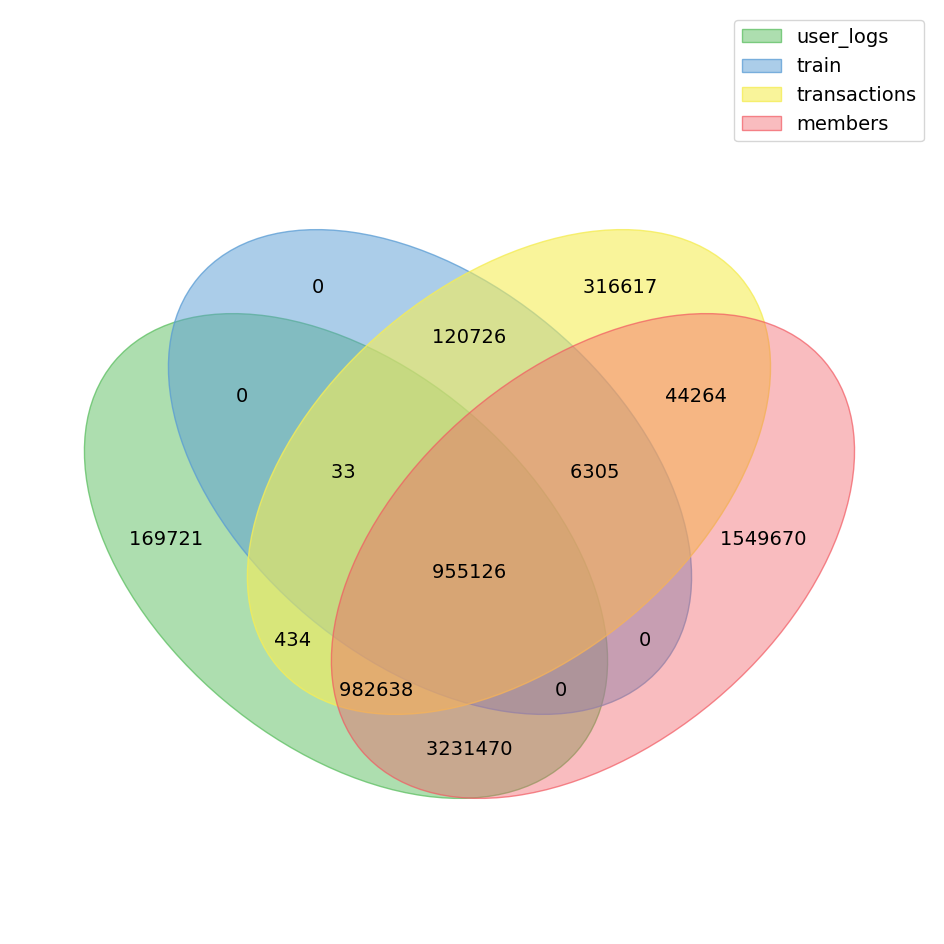

In [ ]:
# 각 데이터의 고객 집합 변수로 저장하기
user_logs_msno = set(user_logs.select(col('msno_num')).distinct().toPandas()['msno_num'])
train_msno = set(train.select(col('msno_num')).distinct().toPandas()['msno_num'])
transactions_msno = set(transactions.select(col('msno_num')).distinct().toPandas()['msno_num'])
members_msno = set(members.select(col('msno_num')).distinct().toPandas()['msno_num'])

# 고객 집합 벤다이어그램으로 나타내기
labels = venn.get_labels([user_logs_msno, train_msno, transactions_msno, members_msno], fill = ['number'])
venn.venn5(labels, names = ['user_logs', 'train', 'transactions', 'members'], figsize = (12, 12))
plt.show()

# **Sampling 가능한 고객 리스트 확보하기**

In [ ]:
# sampling 가능한 msno 리스트 확보하기
A = members.groupBy('msno_num').count()
B = train.groupBy('msno_num').count()
C = transactions.groupBy('msno_num').count()
D = user_logs.groupBy('msno_num').count()

sample_target_msno_all = A.join(B, on = 'msno_num', how = 'inner')\
                          .join(C, on = 'msno_num', how = 'inner')\
                          .join(D, on = 'msno_num', how = 'inner').distinct().drop('count')

total_pool = sample_target_msno_all.count()
print('샘플링이 가능한(4개 데이터셋에서 모두 존재하는) 이용자는 총 {}명입니다.'.format(total_pool))

# sample 비율 정하기
sample_ratio = 0.65
sample_target_msno = sample_target_msno_all.sample(sample_ratio).toPandas()
print('{}명 중 {}%를 샘플링하여 총 {}명을 train 및 test 데이터로 확정합니다.'.format(total_pool, sample_ratio * 100, len(sample_target_msno['msno_num'])))

샘플링이 가능한(4개 데이터셋에서 모두 존재하는) 이용자는 총 955126명입니다.
955126명 중 65.0%를 샘플링하여 총 620777명을 train 및 test 데이터로 확정합니다.


# **샘플링된 데이터 Parquet 형식으로 저장하기**

In [ ]:
table_dict = {train : 'sample_train.parquet', members : 'sample_members.parquet', 
              transactions : 'sample_transactions.parquet', user_logs : 'sample_user_logs.parquet'}
new_table_dict = []
for key, value in table_dict.items():
    key.filter(col('msno_num').isin(list(sample_target_msno['msno_num'])))\
       .coalesce(1).write.mode("overwrite").option("header", "true").parquet('./data/sample (ratio = 0.65)/' + value)